# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [695]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import datetime as dt
from workadays import workdays as wd

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Base_LTN.xlsx"
path2 = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Parametros.xlsx"
df = pd.read_excel(path)
parameters = pd.read_excel(path2)

In [696]:
parameters.set_index("Data referência", inplace=True)
df["Maturity"] = df.apply(lambda row: wd.networkdays(row["DATA_REFERENCIA"], row["DATA_VENCIMENTO"]), axis=1)/252
df.set_index("DATA_REFERENCIA", inplace=True)

In [697]:
df.head()

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity
DATA_REFERENCIA,,,,,
2023-07-27,LTN,2023-10-01,13.1755,977.660457,0.178571
2023-07-27,LTN,2024-01-01,12.6150,950.806347,0.420635
2023-07-27,LTN,2024-04-01,12.0162,927.141688,0.666667
2023-07-27,LTN,2024-07-01,11.4405,905.476539,0.916667
2023-07-27,LTN,2024-10-01,10.9584,884.658175,1.178571


### Generating individuals

In [591]:
N =1200    ### Number of individuals 
p = int(2/3*N)      ## Proportion of individuals generated by method 1
var = 0.5

### 1 - Initial Values of the results of the estimation of the previous day

ref_date_str = "2023-07-27"
ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = ref_date - timedelta(days=1)
previous_parameters = parameters.loc[previous_date][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada.sort_values("Maturity")
b1 = data_estimada["EXPECTATIVA"][0]/100
b2 = data_estimada["EXPECTATIVA"][-1]/100 - data_estimada["EXPECTATIVA"][0]/100
b3 = 0
b4 = 0
lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
    return(beta_previous.T)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

### Selection

In [661]:
### add duration and coupons
values = []

### 40% of the individuals survive
s = int(0.4 * N)

for row in individuals:
    def myval(c):
        df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))+(c[2]*((((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))-(np.exp(-df['Maturity']*c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']*c[5]))/(df['Maturity']*c[5])))-(np.exp(-df['Maturity']*c[5]))))
        df['Calculated_price'] = 1000 / (1 + df['NSS']) ** df['Maturity'] 
        df['Residual'] =  (df['PU'] - df['Calculated_price'])**2
        val = np.sum(df['Residual'])
        return(val)
    
    val = myval(row)
    values.append((val, row)) 
sol = pd.DataFrame(values, columns=['SC', "Parameters"]).sort_values('SC')

selection = sol.sort_values('SC')[0:s]

In [593]:
selection.head()

,SC,Parameters
611,181.250993,"[0.11412105266411347, 0.035266622018368984, 0...."
502,288.720037,"[0.10105220445334448, 0.07296244304626097, 0.0..."
332,291.496266,"[0.10059944505990345, 0.11952243087124964, 0.0..."
624,300.669953,"[0.1118722164659382, 0.11626761109346095, 0.03..."
601,341.080451,"[0.1242636683447454, 0.0018637218400402306, 0...."


### Cross-Over

In [689]:
alpha = 6
next_gen = []


for num in range(N):
    psi = np.random.uniform(0, 1)
    theta_r = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
    theta_s = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
    next_gen.append(psi*theta_r+(1-psi)*theta_s)



### Mutation

In [690]:
pi = 0.35
var = 0.5 ## ajustar a var para a geracao maior que 2
e_mutation = []

for num in range(N):
    e = np.random.normal(0, var, 6)*np.random.choice([0, 1], size=6, p=[1 - pi, pi])
    e_mutation.append(e)

new_individuals = np.array(next_gen) + np.array(next_gen)*np.array(e_mutation)

## add constraints to the parameters


In [691]:
new_individuals

array([[ 0.12057725,  0.01647488,  0.05153945, -0.09959417,  2.89409772,
         0.29732673],
       [ 0.12066261,  0.02498264,  0.05340877, -0.10170373,  2.81222821,
         0.26873424],
       [ 0.12135222,  0.01426206,  0.15634207, -0.1740004 ,  5.60840404,
         1.08649506],
       ...,
       [ 0.1214745 ,  0.02950388,  0.05216882, -0.10246519,  0.84770093,
         1.08056746],
       [ 0.1203029 ,  0.01641742,  0.05190771, -0.09925465,  2.16475996,
         1.09947321],
       [ 0.1217963 ,  0.01415083,  0.05270293,  0.01048149,  2.83443824,
         1.07483231]])

In [692]:
for row in new_individuals:
    def myval(c):
        df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))+(c[2]*((((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))-(np.exp(-df['Maturity']*c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']*c[5]))/(df['Maturity']*c[5])))-(np.exp(-df['Maturity']*c[5]))))
        df['Calculated_price'] = 1000 / (1 + df['NSS']) ** df['Maturity'] 
        df['Residual'] =  (df['PU'] - df['Calculated_price'])**2
        val = np.sum(df['Residual'])
        return(val) 
    val = myval(row)
    values.append((val, row)) 
sol_2 = pd.DataFrame(values, columns=['SC', "Parameters"]).sort_values('SC')

selection = sol_2[0:s]

In [693]:
selection

,SC,Parameters
8348,0.425184,"[0.12088825299046474, 0.01488821028037924, 0.0..."
8257,0.429743,"[0.12098702304317403, 0.014411810252507878, 0...."
7958,0.430089,"[0.12096065334285618, 0.014471853119308611, 0...."
6199,0.430276,"[0.12095915857458389, 0.014471656161735513, 0...."
3646,0.432027,"[0.1208757424815122, 0.015348138403772048, 0.0..."
...,...,...
1941,1.105713,"[0.11975277236733137, 0.018831779608285658, 0...."
2204,1.107498,"[0.12189913205013168, 0.014403601801264477, 0...."
3097,1.116063,"[0.12036669149020429, 0.016363718078643397, 0...."
2101,1.120179,"[0.11820969822018111, 0.019954435886738977, 0...."


In [703]:
dia27 = selection.iloc[0][1]

In [704]:
dia27_anbima = parameters.iloc[-2,1:].values


In [705]:
dia27_anbima

array([0.11607816194564, 0.0166125317003564, 0.0680897147357593,
       -0.0993640836290361, 2.69995231289057, 1.22983028024676],
      dtype=object)

Text(0.5, 1.0, '27/08')

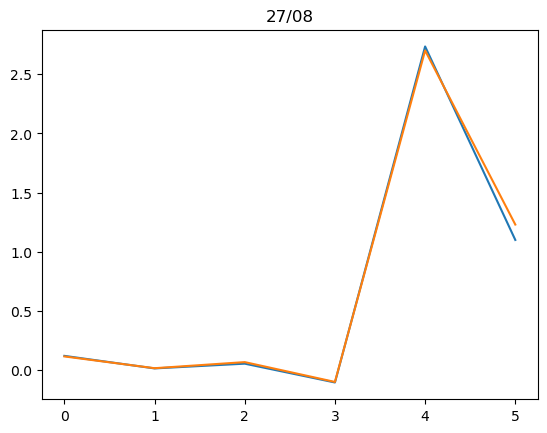

In [706]:
plt.plot(dia27)
plt.plot(dia27_anbima)
plt.title('27/08')